# Airline Sentiment

The dataset used in this notebook is from https://www.crowdflower.com/data-for-everyone/ it's also available on kaggle https://www.kaggle.com/crowdflower/twitter-airline-sentiment

This dataset is about sentiment analysis of twitter - so classifying tweets as positive, neutral or negative.

In this notebook i'll show some different ways of preprocessing textual data, some feature engineering and how this impacts classifier performance. Then we'll compare scores of some classifiers and look at their training curves to see their training behavior and spot any abnormalities.

In [2]:
import pandas as pd

df = pd.read_csv('airline_sentiment.csv', index_col=0)

df.head()

,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
_unit_id,,,,,,,,,,,,,,,,,,,
681448150,FALSE,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.70306E+17,NaN,Eastern Time (US & Canada)
681448153,FALSE,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.70301E+17,NaN,Pacific Time (US & Canada)
681448156,FALSE,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.70301E+17,Lets Play,Central Time (US & Canada)
681448158,FALSE,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.70301E+17,NaN,Pacific Time (US & Canada)
681448159,FALSE,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.70301E+17,NaN,Pacific Time (US & Canada)


So there are many fields in the dataset - mostly related to the assessment procedure and quality. For our taks we're only interested in the sentiment and the text. Let's have a closer look at some of the text:

In [3]:
pd.set_option('max_colwidth', 140)

df[['airline_sentiment', 'text']].head(n=10)

,airline_sentiment,text
_unit_id,,
681448150,neutral,@VirginAmerica What @dhepburn said.
681448153,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
681448156,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
681448158,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
681448159,negative,@VirginAmerica and it's a really big bad thing about it
681448162,negative,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.it's really the only bad thing about flying VA
681448165,positive,"@VirginAmerica yes, nearly every time I fly VX this ‰ÛÏear worm‰Û won‰Ûªt go away :)"
681448167,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
681448169,positive,"@virginamerica Well, I didn't‰Û_but NOW I DO! :-D"


Next up i'm curious how the distribution between the sentiment classes is?

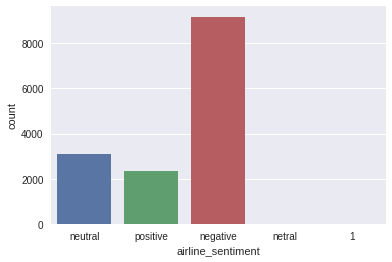

In [4]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x='airline_sentiment', data=df)

Oops! There is some data quality errors there! Let's quickly correct those so we don't confuse our classifier later on.

I'm cheating a bit here - i looked up the tweet with sentiment '1' outside the notebook.

Also i'm fixing is one empty text value which i spotted later down..

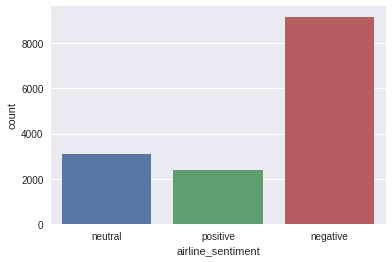

In [5]:
df['text'].fillna(' ', inplace=True)
df['airline_sentiment'] = df['airline_sentiment'] \
    .map({'negative': 'negative', 'neutral': 'neutral', 'netral': 'neutral', 'positive': 'positive', '1': 'positive'})
    
ax = sns.countplot(x='airline_sentiment', data=df)

That looks much better! We're ready for text processing it seems...

## Text preprocessing and making features

I'm curious about the effect of various preprocessing mechanisms on classifier accuracy. Let's process the text in a few different ways to find out.

* **Simple**: Bag-of-Words approach, simple splitting on whitespaces
* **Cleaned**: Preprocessing to remove puntuation, symbols, stopwords, do word stemming etc; bag-of-words to vectorize.
* **No Usernames**: Preprocessing to remove **usernames** as we might not want the classifier to learn those.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.parsing.preprocessing import preprocess_string
from sklearn.preprocessing import LabelEncoder
import re

def no_usernames_hashtags_tokenizer(tweet):
    return [token.strip(' .,?!') for token in tweet.split() if not re.match('^[@#]\w+$', token.strip(' .,?!'))]

vect_simple = CountVectorizer(min_df=25, max_df=0.75)
vect_cleaned = CountVectorizer(min_df=25, max_df=0.75, tokenizer=preprocess_string, stop_words='english')
vect_no_user = CountVectorizer(min_df=25, max_df=0.75, tokenizer=no_usernames_hashtags_tokenizer)
label_encoder = LabelEncoder()

X_simple = vect_simple.fit_transform(df['text'].values)
X_cleaned = vect_cleaned.fit_transform(df['text'].values)
X_no_users = vect_no_user.fit_transform(df['text'].values)
y = label_encoder.fit_transform(df['airline_sentiment'].values)

In [13]:
simple_tokens = set(vect_simple.vocabulary_)
cleaned_tokens = set(vect_cleaned.vocabulary_)
no_user_tokens = set(vect_no_user.vocabulary_)

print(list(no_user_tokens - simple_tokens)[:10])
print(list(cleaned_tokens - simple_tokens)[:10])

['', '&amp;', "we're", "i've", '6', '+', "what's", '7', '@', "don't"]
['head', 'mileag', 'worri', 'issu', 'impress', 'yesterdai', 'folk', 'amaz', 'caus', 'runwai']


In [15]:
print(len(simple_tokens))
print(len(cleaned_tokens))
print(len(no_user_tokens))

988
700
986


In [38]:
no_usernames_hashtags_tokenizer('#aap noot #mies eike test @even?!  iets @frop')

['noot', 'eike', 'test', '@even?!', 'iets']

In [16]:
print(X_simple.shape)
print(X_cleaned.shape)
print(X_no_users.shape)
print(y.shape)

(14640, 988)
(14640, 700)
(14640, 986)
(14640,)


In [17]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(), X_simple, y, cv=ShuffleSplit(n_splits=10, test_size=0.2))
print("Score [simple]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(LogisticRegression(), X_cleaned, y, cv=ShuffleSplit(n_splits=10, test_size=0.2))
print("Score [cleaned]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(LogisticRegression(), X_no_users, y, cv=ShuffleSplit(n_splits=10, test_size=0.2))
print("Score [no users / hashtags]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Score [simple]: 0.7943 (+/- 0.0053)
Score [cleaned]: 0.7726 (+/- 0.0064)
Score [no users / hashtags]: 0.7918 (+/- 0.0087)


In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

scores = cross_val_score(LogisticRegression(multi_class='multinomial', solver='newton-cg'),
                         X_cleaned, y, cv=ShuffleSplit(n_splits=25, test_size=0.2))
print("Score [LogisticRegression]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(MultinomialNB(), X_cleaned, y, cv=ShuffleSplit(n_splits=10, test_size=0.2))
print("Score [MultinomialNB]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(LinearSVC(), X_cleaned, y, cv=ShuffleSplit(n_splits=10, test_size=0.2))
print("Score [LinearSVC]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Score [LogisticRegression]: 0.7693 (+/- 0.0066)
Score [MultinomialNB]: 0.7541 (+/- 0.0063)
Score [LinearSVC]: 0.7690 (+/- 0.0067)


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2)

lr = LogisticRegression()
lr.fit(X_train, y_train)

print(classification_report(y_test, lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.84      0.90      0.87      1838
          1       0.61      0.52      0.56       603
          2       0.75      0.66      0.70       487

avg / total       0.78      0.78      0.78      2928



In [52]:
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
import numpy as np

## From http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title):
    plt.figure()
    plt.title(title)
    #plt.ylim(0.7, 0.9)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_cleaned, y, cv=ShuffleSplit(n_splits=25, test_size=0.2),
        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 6))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

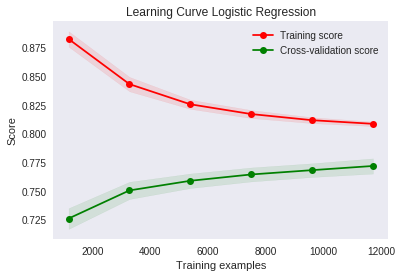

In [53]:
plot_learning_curve(LogisticRegression(), 'Learning Curve Logistic Regression')

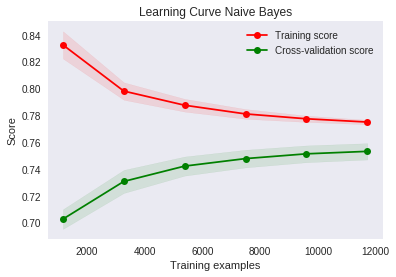

In [54]:
plot_learning_curve(MultinomialNB(), 'Learning Curve Naive Bayes')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

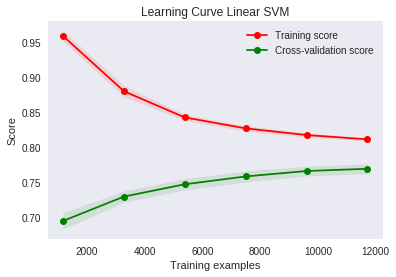

In [61]:
from sklearn.svm import LinearSVC

plot_learning_curve(LinearSVC(), 'Learning Curve Linear SVM')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

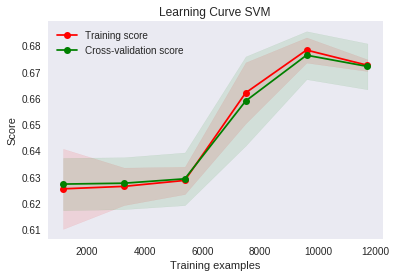

In [63]:
from sklearn.svm import SVC

plot_learning_curve(SVC(), 'Learning Curve SVM')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

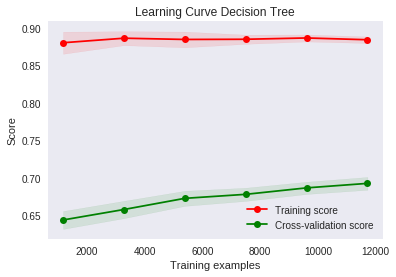

In [62]:
from sklearn.tree import DecisionTreeClassifier

plot_learning_curve(DecisionTreeClassifier(min_samples_split=25), 'Learning Curve Decision Tree')